In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
!apt update && !apt install git

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,738 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,513 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd

Extract Spark/Hadoop and install PyPython dependencies

In [3]:
#######################################
###!@0 START INIT ENVIRONMENT
!ls /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"
###!@0 END INIT ENVIRONMENT

/content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz


Create spark session

In [4]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

1.CDC Diabetes Health Indicators Dataset

  Source: UCI Machine Learning Repository

  URL: CDC Diabetes Health Indicators : https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

  Collection Method: This dataset is derived from the Behavioral Risk Factor Surveillance System (BRFSS) survey conducted by the Centers for Disease Control and Prevention (CDC). The data were collected via telephone surveys.

The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general and their diabetes diagnoses.

Features – 21

Instances – 253680

Format - CSV

**1.1 | Load Datasets**

In [5]:
import requests

cdc_url = 'https://raw.githubusercontent.com/kapsoniiisc/diabetes-dsp-project/refs/heads/main/Dataset/diabetes_binary_health_indicators_BRFSS2015.csv'
pima_url = 'https://raw.githubusercontent.com/kapsoniiisc/diabetes-dsp-project/refs/heads/main/Dataset/diabetes.csv'

# Download the files locally
with open('cdc_data.csv', 'wb') as f:
    f.write(requests.get(cdc_url).content)

with open('pima_data.csv', 'wb') as f:
    f.write(requests.get(pima_url).content)

# Read into Spark
cdc_data = spark.read.csv('cdc_data.csv', header=True, inferSchema=True)
pima_data = spark.read.csv('pima_data.csv', header=True, inferSchema=True)

**1.2 | Import Lib**

In [17]:
################Iomport lib ##############
from pyspark.sql.functions import col, sum, when
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import warnings
from pyspark.sql import functions as F
from pyspark.sql.functions import corr

**1.3 | Data Details**

In [7]:
# Number of rows and columns in cdc_data
cdc_rows = cdc_data.count()
cdc_columns = len(cdc_data.columns)

print(f"CDC Data: {cdc_rows} rows, {cdc_columns} columns")

# Number of rows and columns in pima_data
pima_rows = pima_data.count()
pima_columns = len(pima_data.columns)

print(f"PIMA Data: {pima_rows} rows, {pima_columns} columns")

CDC Data: 253680 rows, 22 columns
PIMA Data: 768 rows, 9 columns


**1.3.1 | CDC Data Details**

In [11]:
cdc_data.printSchema()

root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



**Display Content**

In [9]:
cdc_data.show(5)

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|            0.0|   1.0|     1.0|      1.0|40.0|   1.0|   0.0|                 0.0|         0.0|   0.0|    1.0|              0.0|          1.0|        0.0|    5.0|    18.0|    15.0|     1.0|0.0| 9.0|      4.0|   3.0|
|            0.0|   0.0|     0.0|      0.0|25.0|   1.0|   0.0|                 0.0|         1.0|   0.0|    0.0|              0.0|   

**Count Null/NaN Values**

In [13]:

# Count nulls in each column for cdc_data
cdc_nulls = cdc_data.select(
    [
        sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in cdc_data.columns
    ]
)
cdc_nulls.show()


+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|              0|     0|       0|        0|  0|     0|     0|                   0|           0|     0|      0|                0|            0|          0|      0|       0|       0|       0|  0|  0|        0|     0|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+------------

**No Missing or Null Values**

In [14]:
cdc_data.select('BMI').distinct().count()

84

In [15]:
cdc_data.select('Education').distinct().count()

6

In [16]:
cdc_data.select('Income').distinct().count()

8

**correlation between 'Diabetes_binary' and 'PhysActivity'**

In [18]:


cdc_data.select(corr('Diabetes_binary', 'PhysActivity')).show()

+-----------------------------------+
|corr(Diabetes_binary, PhysActivity)|
+-----------------------------------+
|               -0.11813311489591297|
+-----------------------------------+



**correlation between 'Diabetes_binary' and 'Smoker'**

In [19]:
cdc_data.select(corr('Diabetes_binary', 'Smoker')).show()

+-----------------------------+
|corr(Diabetes_binary, Smoker)|
+-----------------------------+
|         0.060788505640342196|
+-----------------------------+



**Sample Distribution**

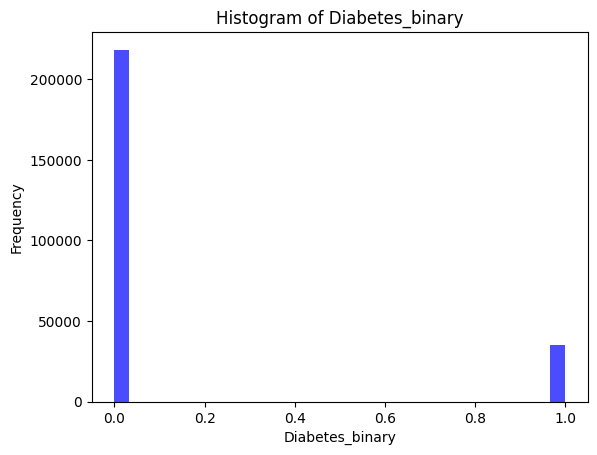

In [20]:

numeric_column = "Diabetes_binary"
data = cdc_data.select(col(numeric_column)).rdd.flatMap(lambda x: x).collect()

plt.hist(data, bins=30, color='blue', alpha=0.7)
plt.title(f"Histogram of {numeric_column}")
plt.xlabel(numeric_column)
plt.ylabel("Frequency")
plt.show()

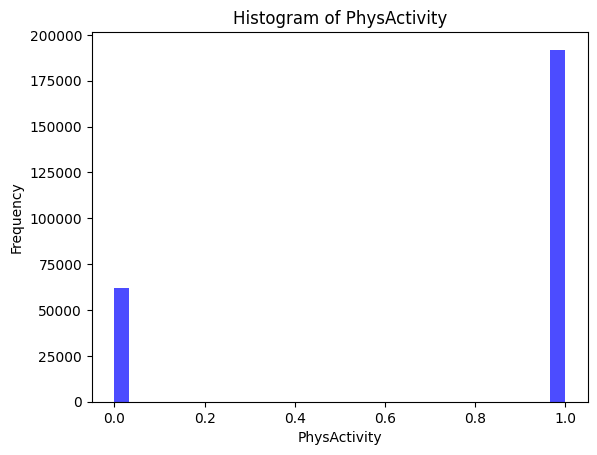

In [21]:
numeric_column = "PhysActivity"
data = cdc_data.select(col(numeric_column)).rdd.flatMap(lambda x: x).collect()

plt.hist(data, bins=30, color='blue', alpha=0.7)
plt.title(f"Histogram of {numeric_column}")
plt.xlabel(numeric_column)
plt.ylabel("Frequency")
plt.show()

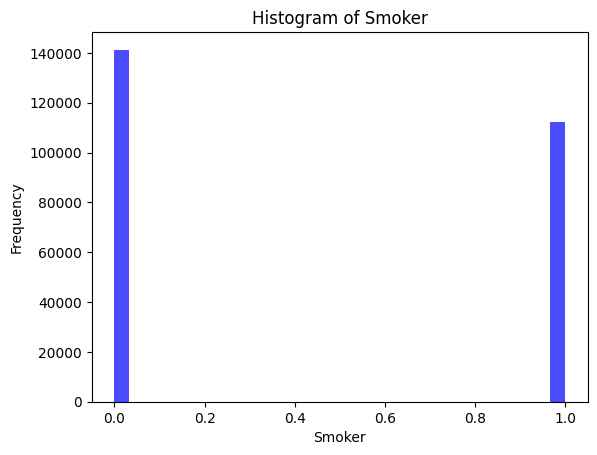

In [22]:
numeric_column = "Smoker"
data = cdc_data.select(col(numeric_column)).rdd.flatMap(lambda x: x).collect()

plt.hist(data, bins=30, color='blue', alpha=0.7)
plt.title(f"Histogram of {numeric_column}")
plt.xlabel(numeric_column)
plt.ylabel("Frequency")
plt.show()

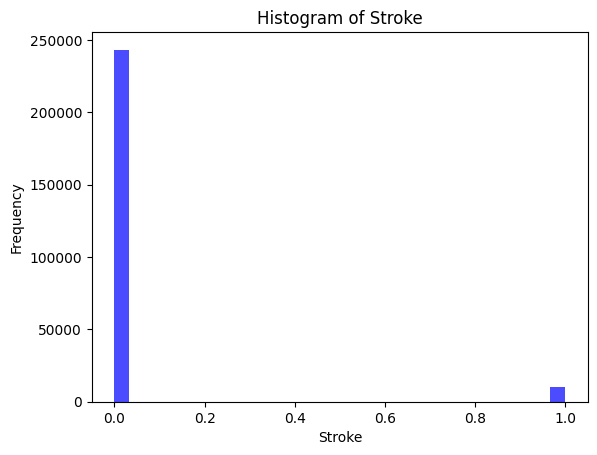

In [23]:
numeric_column = "Stroke"
data = cdc_data.select(col(numeric_column)).rdd.flatMap(lambda x: x).collect()

plt.hist(data, bins=30, color='blue', alpha=0.7)
plt.title(f"Histogram of {numeric_column}")
plt.xlabel(numeric_column)
plt.ylabel("Frequency")
plt.show()

**Correlation Matrix**

In [24]:
numeric_columns = ['Diabetes_binary', 'HighBP', 'HighChol','BMI','Smoker','Stroke',
                   'HeartDiseaseorAttack','PhysActivity','MentHlth','PhysHlth','DiffWalk','Sex','Age']

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
cdc_data_vector = assembler.transform(cdc_data)

correlation_matrix = Correlation.corr(cdc_data_vector, vector_col).head()[0]
print("Correlation Matrix:\n", correlation_matrix.toArray())

Correlation Matrix:
 [[ 1.          0.26312879  0.20027619  0.21684306  0.06078851  0.10581607
   0.17728226 -0.11813311  0.06931508  0.1713367   0.21834435  0.03143
   0.17744187]
 [ 0.26312879  1.          0.2981993   0.21374812  0.09699147  0.12957491
   0.20936121 -0.12526687  0.05645592  0.16121157  0.22361847  0.05220696
   0.34445233]
 [ 0.20027619  0.2981993   1.          0.10672208  0.09129936  0.09262007
   0.18076535 -0.07804619  0.06206915  0.12175053  0.14467154  0.03120533
   0.27231823]
 [ 0.21684306  0.21374812  0.10672208  1.          0.01380447  0.02015266
   0.05290426 -0.14729363  0.08531016  0.12114111  0.19707776  0.0429503
  -0.03661764]
 [ 0.06078851  0.09699147  0.09129936  0.01380447  1.          0.06117267
   0.11444122 -0.08740116  0.09219647  0.11645971  0.12246321  0.09366236
   0.12064108]
 [ 0.10581607  0.12957491  0.09262007  0.02015266  0.06117267  1.
   0.20300194 -0.06915142  0.07017181  0.14894417  0.17656692  0.00297829
   0.1269737 ]
 [ 0.17728226

**Correlation Matrxi Using Panda**

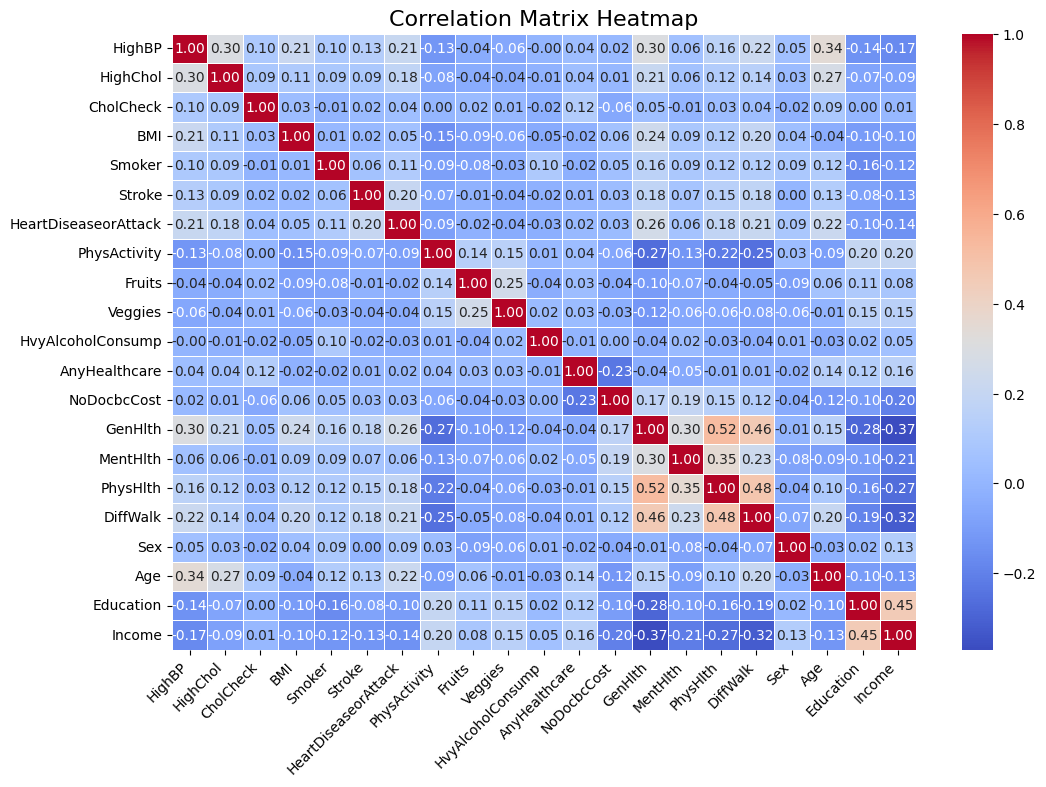

In [31]:


corr_matrix_df = pd.DataFrame(correlation_matrix, columns=numeric_columns, index=numeric_columns)

# Plot the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 10})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

Conclusions from the graph
GenHlth and PhysHlth are highly correleted with each other.(positive relation)

GenHlth and Income are highly correleted with each other .(negetive relation)

Fruits , AnyHealthcare , NoDocbccost and sex are least correlated with Diabetes_binary.

HighBP , HighChol , BMI , smoker , stroke , HeartDiseaseorAttack , PhysActivity , Veggies ,

HvyAlcoholconsump , GenHlth , PhysHlth , Age , Education , Income and DiffWalk have a significant correlation with Diabetes_binary.

**Diabetic People Count**

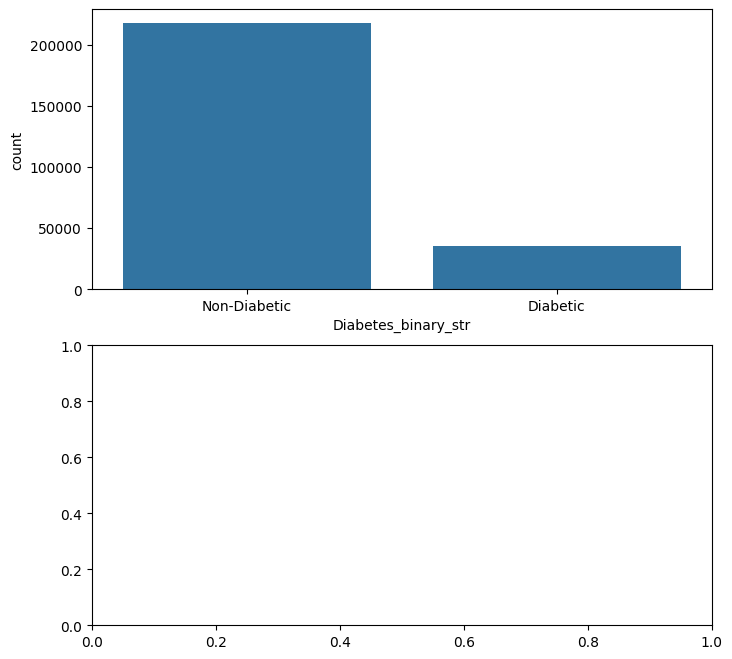

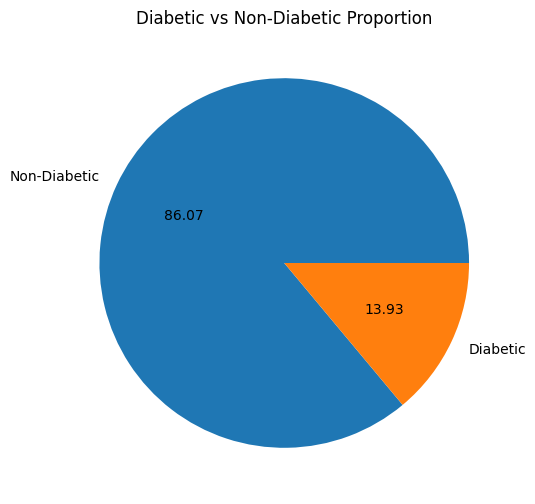

In [32]:

warnings.filterwarnings('ignore')

# Replace 0 with "Non-Diabetic" and 1 with "Diabetic" in 'Diabetes_binary' column
cdc_data = cdc_data.withColumn("Diabetes_binary_str",
                               when(col("Diabetes_binary") == 0, "Non-Diabetic")
                               .otherwise("Diabetic"))

# Convert the relevant column to Pandas for visualization
cdc_data_pd = cdc_data.select("Diabetes_binary_str").toPandas()

# Create subplots
figure1, plot1 = plt.subplots(2, 1, figsize=(8, 8))

# Plot the countplot
sns.countplot(data=cdc_data_pd, x="Diabetes_binary_str", ax=plot1[0])

# Plot the pie chart for diabetic and non-diabetic people
labels = ["Non-Diabetic", "Diabetic"]
diabetes_counts = cdc_data.groupBy("Diabetes_binary").count().toPandas()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_counts['count'], labels=labels, autopct='%.02f')
plt.title('Diabetic vs Non-Diabetic Proportion')
plt.show()

In [33]:
unique_values = {}

# Loop through each column and count unique values
for col_name in cdc_data.columns:
    # Count the number of unique values in each column
    unique_count = cdc_data.select(col_name).distinct().count()
    unique_values[col_name] = unique_count

# Convert the dictionary to a Pandas DataFrame for visualization
unique_values_df = pd.DataFrame(unique_values, index=['unique value count']).transpose()

# Display the DataFrame
print(unique_values_df)

                      unique value count
Diabetes_binary                        2
HighBP                                 2
HighChol                               2
CholCheck                              2
BMI                                   84
Smoker                                 2
Stroke                                 2
HeartDiseaseorAttack                   2
PhysActivity                           2
Fruits                                 2
Veggies                                2
HvyAlcoholConsump                      2
AnyHealthcare                          2
NoDocbcCost                            2
GenHlth                                5
MentHlth                              31
PhysHlth                              31
DiffWalk                               2
Sex                                    2
Age                                   13
Education                              6
Income                                 8
Diabetes_binary_str                    2


**Diabetes Relationship with Variables**

**HighBP vs Diabetes**

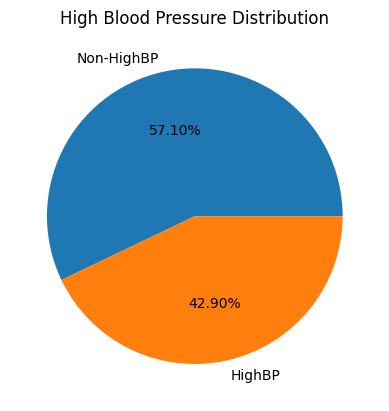

In [34]:
# Group by 'HighBP' and count occurrences
highbp_counts = cdc_data.groupBy("HighBP").count()

# Collect the results into a list (this returns a list of Row objects)
highbp_counts_list = highbp_counts.collect()

# Prepare the data for the pie chart
labels = ["Non-HighBP", "HighBP"]
sizes = [row["count"] for row in highbp_counts_list]

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%.2f%%')
plt.title('High Blood Pressure Distribution')
plt.show()

In [35]:
# Group by both 'HighBP' and 'Diabetes_binary_str', then count the occurrences
crosstab_data = cdc_data.groupBy("HighBP", "Diabetes_binary_str").count()

# Pivot the table to create a crosstab-like structure
crosstab_result = crosstab_data.groupBy("HighBP").pivot("Diabetes_binary_str").sum("count")

# Show the result
crosstab_result.show()

+------+--------+------------+
|HighBP|Diabetic|Non-Diabetic|
+------+--------+------------+
|   0.0|    8742|      136109|
|   1.0|   26604|       82225|
+------+--------+------------+



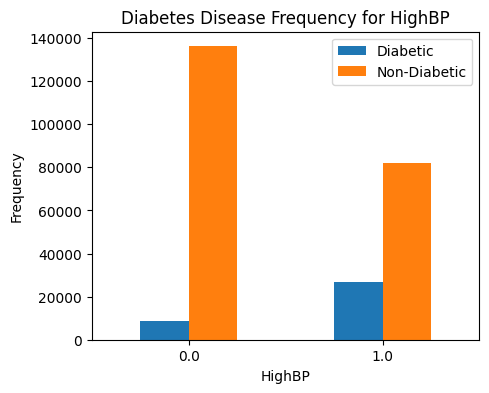

In [36]:
# Group by 'HighBP' and 'Diabetes_binary_str' and count occurrences
crosstab_data = cdc_data.groupBy("HighBP", "Diabetes_binary_str").count()

# Pivot the table to create a crosstab-like structure
crosstab_result = crosstab_data.groupBy("HighBP").pivot("Diabetes_binary_str").sum("count")

# Collect the result into a Pandas DataFrame (for plotting)
crosstab_pandas = crosstab_result.toPandas()

# Plotting using Matplotlib
crosstab_pandas.set_index('HighBP').plot(kind='bar', figsize=(5, 4))

plt.title('Diabetes Disease Frequency for HighBP')
plt.xlabel("HighBP")
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Optional: for better readability of x labels
plt.show()

In [39]:
# Group by 'Diabetes_binary_str' and 'HighBP' to count occurrences
highbp_count = cdc_data.groupBy("Diabetes_binary_str", "HighBP").count().withColumnRenamed("count", "highbp_count")

# Group by 'Diabetes_binary_str' to get the total count per category
total_count = cdc_data.groupBy("Diabetes_binary_str").count().withColumnRenamed("count", "total_count")

# Join the two DataFrames on 'Diabetes_binary_str'
joined_data = highbp_count.join(total_count, on="Diabetes_binary_str", how="inner")

# Calculate the percentage (highbp_count / total_count) * 100
result = joined_data.withColumn(
    "percentage",
    (F.col("highbp_count") / F.col("total_count")) * 100
)

# Show the result
result.select("Diabetes_binary_str", "HighBP", "percentage").show()

+-------------------+------+------------------+
|Diabetes_binary_str|HighBP|        percentage|
+-------------------+------+------------------+
|           Diabetic|   0.0| 24.73264301476829|
|           Diabetic|   1.0| 75.26735698523171|
|       Non-Diabetic|   0.0|62.339809649436184|
|       Non-Diabetic|   1.0|37.660190350563816|
+-------------------+------+------------------+



**High BP vs Diabetes: Conclusion**
HighBP is a play a major role in Diabetes. When cases of high BP increases then cases of Diabetes also increases.

**HighCholestrol vs Diabetes**

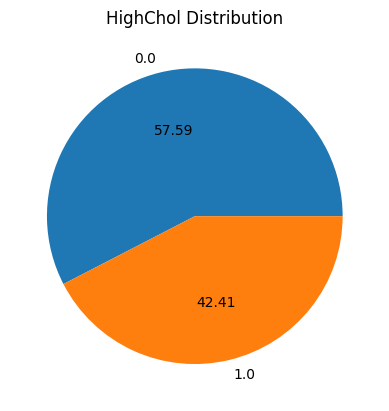

In [40]:
# Group by 'HighChol' and count the occurrences
highchol_count = cdc_data.groupBy("HighChol").count()

# Collect the result into a Pandas DataFrame (for plotting)
highchol_pandas = highchol_count.toPandas()

# Plotting the pie chart using Matplotlib
labels = highchol_pandas["HighChol"].values
sizes = highchol_pandas["count"].values

plt.pie(sizes, labels=labels, autopct='%.02f')
plt.title("HighChol Distribution")
plt.show()

In [41]:
# Group by 'HighChol' and 'Diabetes_binary_str' and count occurrences
crosstab_data = cdc_data.groupBy("HighChol", "Diabetes_binary_str").count()

# Pivot the table to create a crosstab-like structure
crosstab_result = crosstab_data.groupBy("HighChol").pivot("Diabetes_binary_str").sum("count")

# Show the result
crosstab_result.show()

+--------+--------+------------+
|HighChol|Diabetic|Non-Diabetic|
+--------+--------+------------+
|     0.0|   11660|      134429|
|     1.0|   23686|       83905|
+--------+--------+------------+



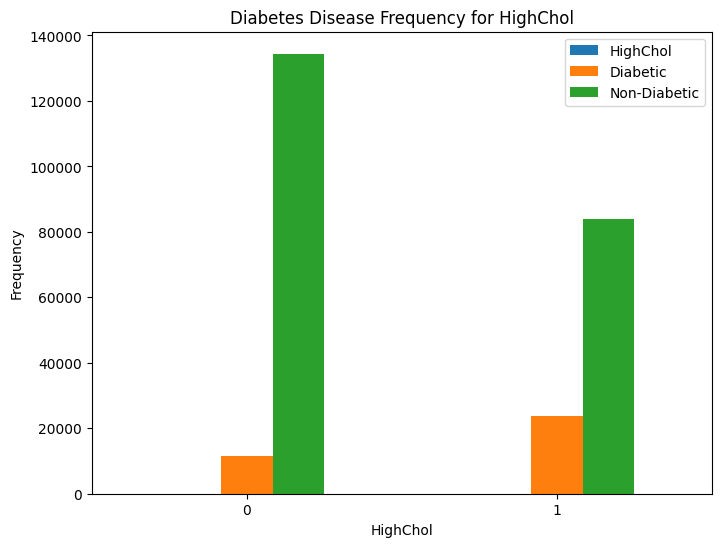

In [42]:
crosstab_data = cdc_data.groupBy("HighChol", "Diabetes_binary_str").count()

# Pivot the table to create a crosstab-like structure
crosstab_result = crosstab_data.groupBy("HighChol").pivot("Diabetes_binary_str").sum("count")

# Convert the result to a Pandas DataFrame for plotting
crosstab_pandas = crosstab_result.toPandas()

# Plotting the bar chart
crosstab_pandas.plot(kind="bar", figsize=(8, 6))

plt.title('Diabetes Disease Frequency for HighChol')
plt.xlabel("HighChol")
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # To ensure labels are horizontal
plt.show()

In [43]:
# Step 1: Count occurrences of each 'HighChol' for each 'Diabetes_binary_str'
highchol_count = cdc_data.groupBy("Diabetes_binary_str", "HighChol").count()

# Step 2: Get the total count of 'HighChol' values per 'Diabetes_binary_str'
total_count = cdc_data.groupBy("Diabetes_binary_str").count().withColumnRenamed("count", "total_count")

# Step 3: Join the two DataFrames on 'Diabetes_binary_str'
joined_data = highchol_count.join(total_count, on="Diabetes_binary_str", how="inner")

# Step 4: Calculate the percentage of each 'HighChol' value for each 'Diabetes_binary_str'
result = joined_data.withColumn(
    "percentage",
    (F.col("count") / F.col("total_count")) * 100
)

# Show the result
result.select("Diabetes_binary_str", "HighChol", "percentage").show()

+-------------------+--------+------------------+
|Diabetes_binary_str|HighChol|        percentage|
+-------------------+--------+------------------+
|           Diabetic|     0.0| 32.98817405081198|
|           Diabetic|     1.0| 67.01182594918804|
|       Non-Diabetic|     0.0|61.570346350087476|
|       Non-Diabetic|     1.0|38.429653649912524|
+-------------------+--------+------------------+



**High Cholesterol vs Diabetes: conclusions**
HighChol is a play a major role in Diabetes. When cases of highChol increases, then cases of Diabetes also increases

**[High BP + High Cholesterol] vs Diabetes**

In [44]:
# Step 1: Count occurrences of each 'Diabetes_binary_str' for combinations of 'HighBP' and 'HighChol'
diabetes_count = cdc_data.groupBy("HighBP", "HighChol", "Diabetes_binary_str").count()

# Step 2: Get the total count of records per combination of 'HighBP' and 'HighChol'
total_count = cdc_data.groupBy("HighBP", "HighChol").count().withColumnRenamed("count", "total_count")

# Step 3: Join the two DataFrames on 'HighBP' and 'HighChol'
joined_data = diabetes_count.join(total_count, on=["HighBP", "HighChol"], how="inner")

# Step 4: Calculate the percentage of each 'Diabetes_binary_str' for each 'HighBP' and 'HighChol' combination
result = joined_data.withColumn(
    "percentage",
    (F.col("count") / F.col("total_count")) * 100
)

# Show the result
result.select("HighBP", "HighChol", "Diabetes_binary_str", "percentage").show()

+------+--------+-------------------+------------------+
|HighBP|HighChol|Diabetes_binary_str|        percentage|
+------+--------+-------------------+------------------+
|   1.0|     1.0|       Non-Diabetic| 70.28611197030622|
|   1.0|     1.0|           Diabetic| 29.71388802969378|
|   0.0|     1.0|           Diabetic|10.419044513288766|
|   0.0|     1.0|       Non-Diabetic| 89.58095548671123|
|   1.0|     0.0|       Non-Diabetic| 83.26654440897462|
|   1.0|     0.0|           Diabetic| 16.73345559102538|
|   0.0|     0.0|       Non-Diabetic| 95.81142072213501|
|   0.0|     0.0|           Diabetic| 4.188579277864992|
+------+--------+-------------------+------------------+



Here we are using the Pandas

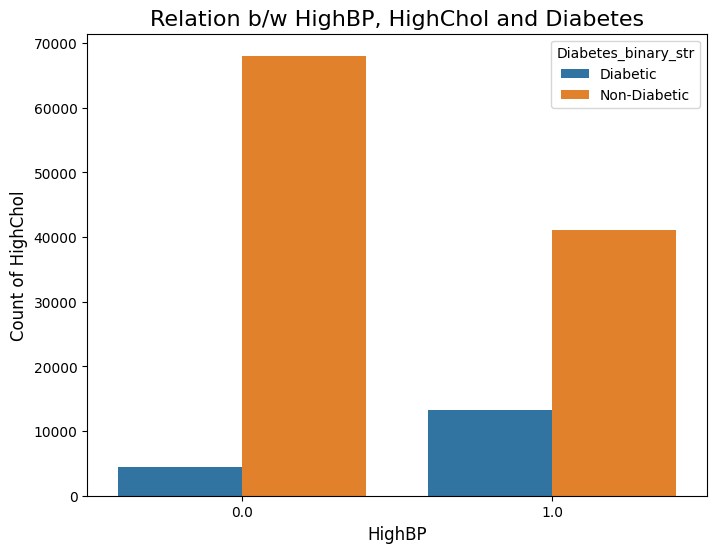

In [45]:
# Step 1: Group the data by 'HighBP', 'HighChol', and 'Diabetes_binary_str' and calculate the count
grouped_data = cdc_data.groupBy("HighBP", "HighChol", "Diabetes_binary_str").count()

# Step 2: Convert the grouped result to a Pandas DataFrame
grouped_pandas = grouped_data.toPandas()

# Step 3: Create a bar plot using Seaborn and Matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x="HighBP", y="count", hue="Diabetes_binary_str", data=grouped_pandas, ci=None)

# Set the title and labels
plt.title("Relation b/w HighBP, HighChol and Diabetes", fontsize=16)
plt.xlabel("HighBP", fontsize=12)
plt.ylabel("Count of HighChol", fontsize=12)
plt.xticks(rotation=0)

# Show the plot
plt.show()

**[ HighBP + High Cholestrol ] vs Diabetes : Conclusions**

Acording to this data, HighBP and HighChol both togather increase the risk of diabetes.

**BMI vs Diabetes**

In [46]:
import plotly.express as px

# Step 1: Group the data by 'BMI' and count the occurrences
bmi_count = cdc_data.groupBy("BMI").count()

# Step 2: Convert the result to a Pandas DataFrame
bmi_count_pandas = bmi_count.toPandas()

# Step 3: Create a treemap using Plotly Express
fig = px.treemap(bmi_count_pandas,
                 path=['BMI'],
                 values='count',
                 title="BMI Counts")

# Step 4: Show the treemap
fig.show()

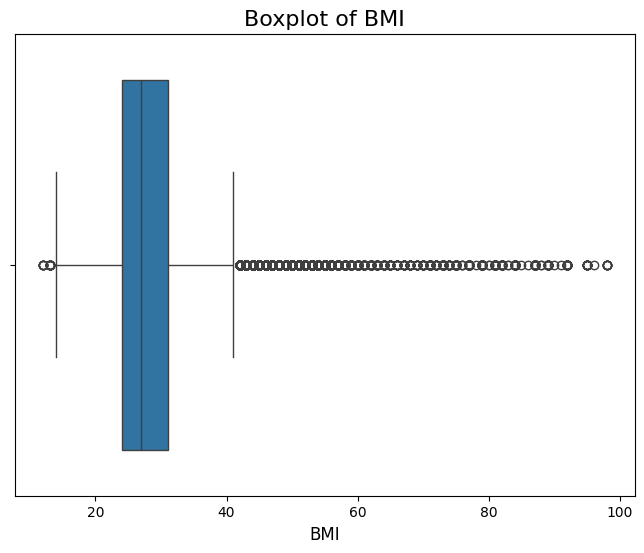

In [47]:
# Step 1: Compute summary statistics for the 'BMI' column
bmi_summary = cdc_data.describe(["BMI"])

# Step 2: Convert the summary statistics to Pandas DataFrame
bmi_summary_pd = bmi_summary.toPandas()

# Step 3: Create a boxplot using Seaborn and Matplotlib
plt.figure(figsize=(8, 6))
sns.boxplot(x=cdc_data.toPandas()["BMI"])

# Set the title
plt.title("Boxplot of BMI", fontsize=16)
plt.xlabel("BMI", fontsize=12)

# Show the plot
plt.show()

**Split the data into multiple group**

First Group

In [48]:
# Step 1: Filter the data where BMI <= 20
filtered_data = cdc_data.filter(cdc_data["BMI"] <= 20)

# Step 2: Group the filtered data by 'Diabetes_binary' and count occurrences
diabetes_count = filtered_data.groupBy("Diabetes_binary").count()

# Step 3: Show the result
diabetes_count.show()

+---------------+-----+
|Diabetes_binary|count|
+---------------+-----+
|            0.0|12877|
|            1.0|  545|
+---------------+-----+



Second Group

In [49]:
# Step 1: Filter the data where BMI is between 20 and 50
BMI_2 = cdc_data.filter((cdc_data["BMI"] > 20) & (cdc_data["BMI"] <= 50))

# Step 2: Get the length (count) of the filtered dataset
length_of_BMI_2 = BMI_2.count()

# Print the length
print("len of BMI_2 : ", length_of_BMI_2)

len of BMI_2 :  238083


Third Group

In [50]:
# Step 1: Filter the data where BMI is between 20 and 50
filtered_data = cdc_data.filter((cdc_data["BMI"] > 20) & (cdc_data["BMI"] <= 50))

# Step 2: Group the filtered data by 'Diabetes_binary_str' and count occurrences
diabetes_count = filtered_data.groupBy("Diabetes_binary_str").count()

# Step 3: Show the result
diabetes_count.show()

+-------------------+------+
|Diabetes_binary_str| count|
+-------------------+------+
|           Diabetic| 34098|
|       Non-Diabetic|203985|
+-------------------+------+



In [51]:
# Step 1: Filter the data where BMI is between 50 and 100
filtered_data = cdc_data.filter((cdc_data["BMI"] > 50) & (cdc_data["BMI"] <= 100))

# Step 2: Group the filtered data by 'Diabetes_binary' and count occurrences
diabetes_count = filtered_data.groupBy("Diabetes_binary").count()

# Step 3: Show the result
diabetes_count.show()

+---------------+-----+
|Diabetes_binary|count|
+---------------+-----+
|            0.0| 1472|
|            1.0|  703|
+---------------+-----+



**BMI vs Diabetes: Conclusions**
Most numbers of diabetic people's BMI is between 20 to 50

So we can say 20-50 BMI group have significant effect on Diabetes

BMI have some outliers

**Smokers vs Diabetes**

In [52]:
# Step 1: Group the data by 'Smoker' and 'Diabetes_binary_str'
cross_tab = cdc_data.groupBy("Smoker", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()

+------+-------------------+------+
|Smoker|Diabetes_binary_str| count|
+------+-------------------+------+
|   1.0|           Diabetic| 18317|
|   0.0|       Non-Diabetic|124228|
|   0.0|           Diabetic| 17029|
|   1.0|       Non-Diabetic| 94106|
+------+-------------------+------+



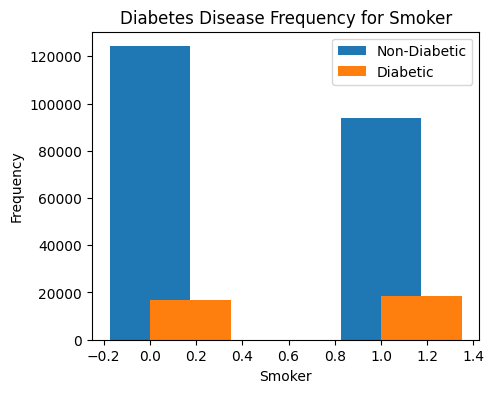

In [53]:


# Step 1: Group the data by 'Smoker' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("Smoker", "Diabetes_binary_str").count()

# Step 2: Collect the result and create a dictionary to store counts
count_dict = {}
for row in cross_tab.collect():
    smoker = row['Smoker']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    # Add the count to the dictionary
    if smoker not in count_dict:
        count_dict[smoker] = {}
    count_dict[smoker][diabetes_status] = count

# Step 3: Prepare the data for plotting (convert dictionary to format suitable for plotting)
smoker_labels = sorted(count_dict.keys())
non_diabetic = [count_dict[smoker].get("Non-Diabetic", 0) for smoker in smoker_labels]
diabetic = [count_dict[smoker].get("Diabetic", 0) for smoker in smoker_labels]

# Step 4: Plot the data
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(smoker_labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(smoker_labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 5: Customize the plot
ax.set_title('Diabetes Disease Frequency for Smoker')
ax.set_xlabel("Smoker")
ax.set_ylabel('Frequency')
ax.legend()

# Step 6: Show the plot
plt.show()


**Smoker vs Diabetes**
Acording to this data, Only smoking has a minor effect on diabetes.

Smoking is injurious to health.

**Heavy Alcohol Consumption vs Diabetes**

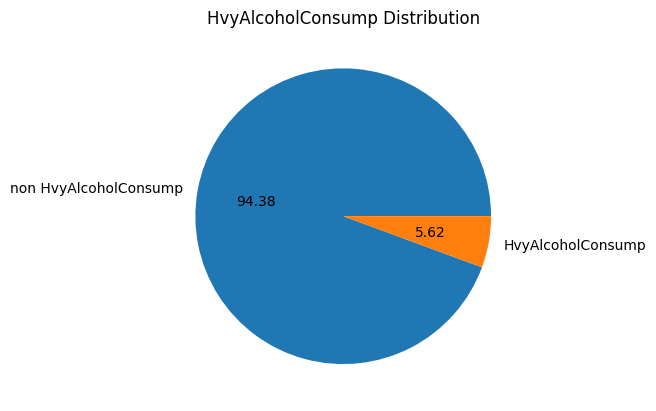

In [54]:
# Step 1: Count the occurrences of each value in the 'HvyAlcoholConsump' column
alcohol_counts = cdc_data.groupBy("HvyAlcoholConsump").count()

# Step 2: Collect the result into a list
alcohol_counts_list = alcohol_counts.collect()

# Step 3: Prepare the data for plotting
labels = ["non HvyAlcoholConsump", "HvyAlcoholConsump"]
sizes = [row['count'] for row in alcohol_counts_list]

# Step 4: Create a pie chart
plt.pie(sizes, labels=labels, autopct='%.02f')
plt.title("HvyAlcoholConsump Distribution")
plt.show()

In [55]:
# Step 1: Group the data by 'HvyAlcoholConsump' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("HvyAlcoholConsump", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()

+-----------------+-------------------+------+
|HvyAlcoholConsump|Diabetes_binary_str| count|
+-----------------+-------------------+------+
|              1.0|           Diabetic|   832|
|              0.0|       Non-Diabetic|204910|
|              0.0|           Diabetic| 34514|
|              1.0|       Non-Diabetic| 13424|
+-----------------+-------------------+------+



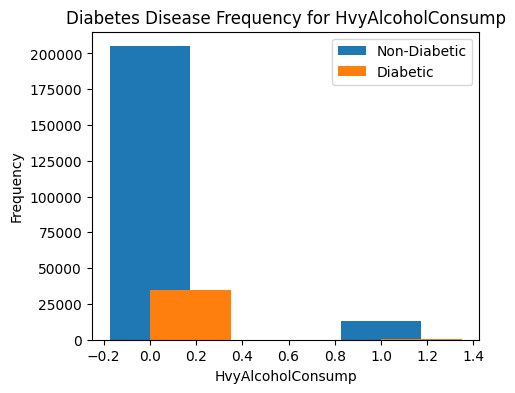

In [56]:


# Step 1: Group the data by 'HvyAlcoholConsump' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("HvyAlcoholConsump", "Diabetes_binary_str").count()

# Step 2: Collect the results into a list of Rows
cross_tab_data = cross_tab.collect()

# Step 3: Organize the data for plotting
# Create a dictionary to hold counts for each category of 'HvyAlcoholConsump'
count_dict = {}
for row in cross_tab_data:
    hvy_alcohol = row['HvyAlcoholConsump']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    if hvy_alcohol not in count_dict:
        count_dict[hvy_alcohol] = {}
    count_dict[hvy_alcohol][diabetes_status] = count

# Step 4: Prepare the data for the plot
labels = sorted(count_dict.keys())
non_diabetic = [count_dict[hvy].get("Non-Diabetic", 0) for hvy in labels]
diabetic = [count_dict[hvy].get("Diabetic", 0) for hvy in labels]

# Step 5: Create a bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 6: Customize the plot
ax.set_title('Diabetes Disease Frequency for HvyAlcoholConsump')
ax.set_xlabel("HvyAlcoholConsump")
ax.set_ylabel('Frequency')
ax.legend()

# Step 7: Show the plot
plt.show()


**Heavy Alcohol Consumption vs Diabetes**

Acording to this data,There is not enugh information here about heavy alcohol consumption, so we can not predict the effect of HvyAlcoholConsump on Diabetes, despites its effect on health otherwise

**Life Style : PhysActivity, Fruits and Veggies effect on Diabetes**

In [57]:
# Step 1: Group the data by 'PhysActivity' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("PhysActivity", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()

+------------+-------------------+------+
|PhysActivity|Diabetes_binary_str| count|
+------------+-------------------+------+
|         1.0|           Diabetic| 22287|
|         0.0|       Non-Diabetic| 48701|
|         0.0|           Diabetic| 13059|
|         1.0|       Non-Diabetic|169633|
+------------+-------------------+------+



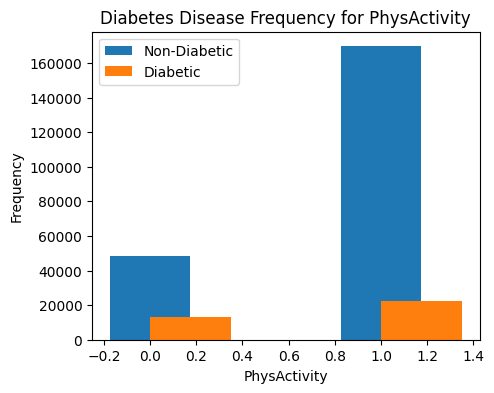

In [58]:


# Step 1: Group the data by 'PhysActivity' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("PhysActivity", "Diabetes_binary_str").count()

# Step 2: Collect the results into a list of Rows
cross_tab_data = cross_tab.collect()

# Step 3: Organize the data for plotting
# Create a dictionary to hold counts for each category of 'PhysActivity'
count_dict = {}
for row in cross_tab_data:
    phys_activity = row['PhysActivity']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    if phys_activity not in count_dict:
        count_dict[phys_activity] = {}
    count_dict[phys_activity][diabetes_status] = count

# Step 4: Prepare the data for the plot
labels = sorted(count_dict.keys())
non_diabetic = [count_dict[phys].get("Non-Diabetic", 0) for phys in labels]
diabetic = [count_dict[phys].get("Diabetic", 0) for phys in labels]

# Step 5: Create a bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 6: Customize the plot
ax.set_title('Diabetes Disease Frequency for PhysActivity')
ax.set_xlabel("PhysActivity")
ax.set_ylabel('Frequency')
ax.legend()

# Step 7: Show the plot
plt.show()


In [59]:
# Step 1: Group the data by 'Fruits' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("Fruits", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()


+------+-------------------+------+
|Fruits|Diabetes_binary_str| count|
+------+-------------------+------+
|   1.0|           Diabetic| 20693|
|   0.0|       Non-Diabetic| 78129|
|   0.0|           Diabetic| 14653|
|   1.0|       Non-Diabetic|140205|
+------+-------------------+------+



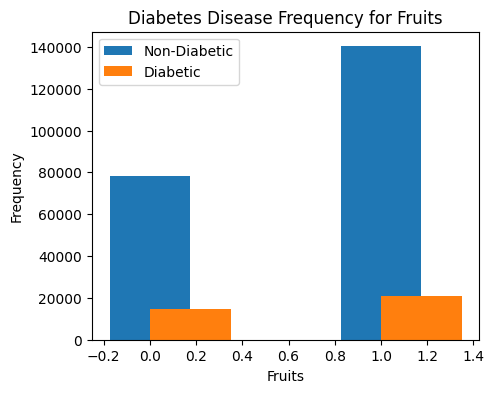

In [60]:

# Step 1: Group the data by 'Fruits' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("Fruits", "Diabetes_binary_str").count()

# Step 2: Collect the results into a list of Rows
cross_tab_data = cross_tab.collect()

# Step 3: Organize the data for plotting
# Create a dictionary to hold counts for each category of 'Fruits'
count_dict = {}
for row in cross_tab_data:
    fruits = row['Fruits']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    if fruits not in count_dict:
        count_dict[fruits] = {}
    count_dict[fruits][diabetes_status] = count

# Step 4: Prepare the data for the plot
labels = sorted(count_dict.keys())
non_diabetic = [count_dict[fruit].get("Non-Diabetic", 0) for fruit in labels]
diabetic = [count_dict[fruit].get("Diabetic", 0) for fruit in labels]

# Step 5: Create a bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 6: Customize the plot
ax.set_title('Diabetes Disease Frequency for Fruits')
ax.set_xlabel("Fruits")
ax.set_ylabel('Frequency')
ax.legend()

# Step 7: Show the plot
plt.show()


In [61]:
# Step 1: Group the data by 'Veggies' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("Veggies", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()

+-------+-------------------+------+
|Veggies|Diabetes_binary_str| count|
+-------+-------------------+------+
|    1.0|           Diabetic| 26736|
|    0.0|       Non-Diabetic| 39229|
|    0.0|           Diabetic|  8610|
|    1.0|       Non-Diabetic|179105|
+-------+-------------------+------+



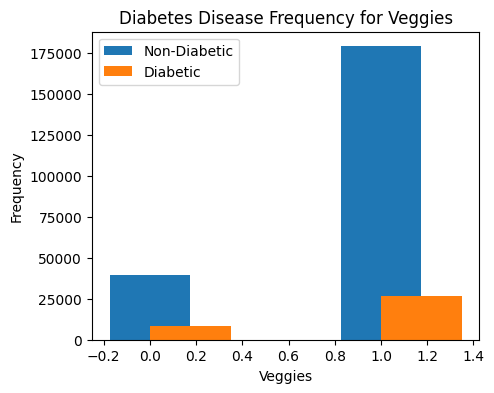

In [62]:

# Step 1: Group the data by 'Veggies' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("Veggies", "Diabetes_binary_str").count()

# Step 2: Collect the results into a list of Rows
cross_tab_data = cross_tab.collect()

# Step 3: Organize the data for plotting
# Create a dictionary to hold counts for each category of 'Veggies'
count_dict = {}
for row in cross_tab_data:
    veggies = row['Veggies']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    if veggies not in count_dict:
        count_dict[veggies] = {}
    count_dict[veggies][diabetes_status] = count

# Step 4: Prepare the data for the plot
labels = sorted(count_dict.keys())
non_diabetic = [count_dict[veg].get("Non-Diabetic", 0) for veg in labels]
diabetic = [count_dict[veg].get("Diabetic", 0) for veg in labels]

# Step 5: Create a bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 6: Customize the plot
ax.set_title('Diabetes Disease Frequency for Veggies')
ax.set_xlabel("Veggies")
ax.set_ylabel('Frequency')
ax.legend()

# Step 7: Show the plot
plt.show()


**LifeStyle vs Diabetes**

1.Physical activity reduces the risk of diabetes.

2.Eating at least one fruit a day reduces the risk of diabetes.

3.Eating at least one veggies a day slower the risk of diabetes.

4.Healthy lifestyle is the key of healthy body.

**Healthcare services : AnyHealthcare and NoDocbcCost's effect on Diabetes**

In [63]:
# Step 1: Group the data by 'AnyHealthcare' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("AnyHealthcare", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()

+-------------+-------------------+------+
|AnyHealthcare|Diabetes_binary_str| count|
+-------------+-------------------+------+
|          1.0|           Diabetic| 33924|
|          0.0|       Non-Diabetic| 10995|
|          0.0|           Diabetic|  1422|
|          1.0|       Non-Diabetic|207339|
+-------------+-------------------+------+



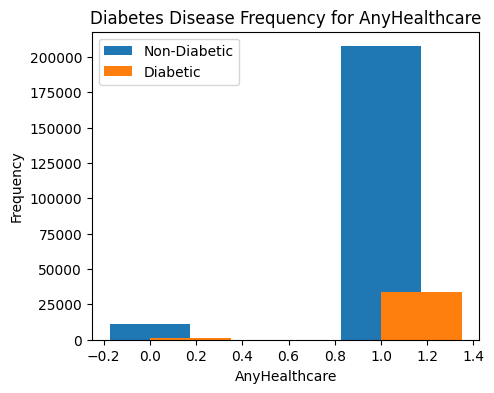

In [64]:


# Step 1: Group the data by 'AnyHealthcare' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("AnyHealthcare", "Diabetes_binary_str").count()

# Step 2: Collect the results into a list of Rows
cross_tab_data = cross_tab.collect()

# Step 3: Organize the data for plotting
# Create a dictionary to hold counts for each category of 'AnyHealthcare'
count_dict = {}
for row in cross_tab_data:
    healthcare = row['AnyHealthcare']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    if healthcare not in count_dict:
        count_dict[healthcare] = {}
    count_dict[healthcare][diabetes_status] = count

# Step 4: Prepare the data for the plot
labels = sorted(count_dict.keys())
non_diabetic = [count_dict[hc].get("Non-Diabetic", 0) for hc in labels]
diabetic = [count_dict[hc].get("Diabetic", 0) for hc in labels]

# Step 5: Create a bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 6: Customize the plot
ax.set_title('Diabetes Disease Frequency for AnyHealthcare')
ax.set_xlabel("AnyHealthcare")
ax.set_ylabel('Frequency')
ax.legend()

# Step 7: Show the plot
plt.show()


In [65]:
# Step 1: Group the data by 'NoDocbcCost' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("NoDocbcCost", "Diabetes_binary_str").count()

# Step 2: Show the result
cross_tab.show()

+-----------+-------------------+------+
|NoDocbcCost|Diabetes_binary_str| count|
+-----------+-------------------+------+
|        1.0|           Diabetic|  3742|
|        0.0|       Non-Diabetic|200722|
|        0.0|           Diabetic| 31604|
|        1.0|       Non-Diabetic| 17612|
+-----------+-------------------+------+



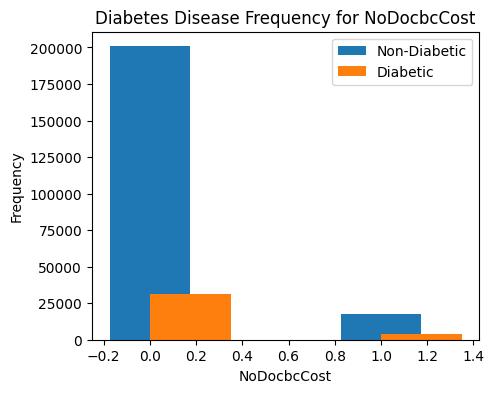

In [67]:

# Step 1: Group the data by 'NoDocbcCost' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("NoDocbcCost", "Diabetes_binary_str").count()

# Step 2: Collect the results into a list of Rows
cross_tab_data = cross_tab.collect()

# Step 3: Organize the data for plotting
# Create a dictionary to hold counts for each category of 'NoDocbcCost'
count_dict = {}
for row in cross_tab_data:
    docbc_cost = row['NoDocbcCost']
    diabetes_status = row['Diabetes_binary_str']
    count = row['count']

    if docbc_cost not in count_dict:
        count_dict[docbc_cost] = {}
    count_dict[docbc_cost][diabetes_status] = count

# Step 4: Prepare the data for the plot
labels = sorted(count_dict.keys())
non_diabetic = [count_dict[docbc_cost].get("Non-Diabetic", 0) for docbc_cost in labels]
diabetic = [count_dict[docbc_cost].get("Diabetic", 0) for docbc_cost in labels]

# Step 5: Create a bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(5, 4))

# Create bars for Non-Diabetic and Diabetic categories
ax.bar(labels, non_diabetic, width=bar_width, label="Non-Diabetic", align="center")
ax.bar(labels, diabetic, width=bar_width, label="Diabetic", align="edge")

# Step 6: Customize the plot
ax.set_title('Diabetes Disease Frequency for NoDocbcCost')
ax.set_xlabel("NoDocbcCost")
ax.set_ylabel('Frequency')  # Corrected here
ax.legend()

# Step 7: Show the plot
plt.show()



**Health : GenHlth , MentHlth , PhysHlth and DiffWalk's vs Diabetes**

In [68]:
# Step 1: Group the data by 'GenHlth' and count the occurrences
genhlth_data = cdc_data.groupBy("GenHlth").count()

# Step 2: Collect the result into a Pandas DataFrame
genhlth_df = genhlth_data.toPandas()

# Step 3: Create the Treemap using Plotly Express
fig = px.treemap(genhlth_df, path=['GenHlth'], values='count', title="GenHlth counts")

# Step 4: Show the Treemap
fig.show()

In [69]:
# Step 1: Group the data by 'GenHlth' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("GenHlth", "Diabetes_binary_str").count()

# Step 2: Pivot the data to create a cross-tabulation
cross_tab_pivot = cross_tab.groupBy("GenHlth").pivot("Diabetes_binary_str").sum("count")

# Step 3: Show the result
cross_tab_pivot.show()


+-------+--------+------------+
|GenHlth|Diabetic|Non-Diabetic|
+-------+--------+------------+
|    1.0|    1140|       44159|
|    4.0|    9790|       21780|
|    3.0|   13457|       62189|
|    2.0|    6381|       82703|
|    5.0|    4578|        7503|
+-------+--------+------------+



In [71]:
# Step 1: Group the data by 'MentHlth' and count the occurrences
menthlth_counts = cdc_data.groupBy("MentHlth").count()

# Step 2: Collect the result into a list of rows
menthlth_counts_list = menthlth_counts.collect()

# Step 3: Convert the collected data into a dictionary format suitable for a treemap
data_dict = {"MentHlth": [], "count": []}
for row in menthlth_counts_list:
    data_dict["MentHlth"].append(row["MentHlth"])
    data_dict["count"].append(row["count"])

# Step 4: Generate the treemap using plotly
fig = px.treemap(data_dict, path=["MentHlth"], values="count", title="MentHlth counts")

# Step 5: Show the treemap
fig.show()

In [72]:
# Step 1: Group by 'MentHlth' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("MentHlth", "Diabetes_binary_str").count()

# Step 2: Pivot the data to get the cross-tabulation format
cross_tab_pivot = cross_tab.groupBy("MentHlth").pivot("Diabetes_binary_str").agg(F.sum("count"))

# Step 3: Show the result
cross_tab_pivot.show()

+--------+--------+------------+
|MentHlth|Diabetic|Non-Diabetic|
+--------+--------+------------+
|     8.0|     110|         529|
|     0.0|   23403|      152277|
|     7.0|     405|        2695|
|    29.0|      30|         128|
|    18.0|      20|          77|
|     1.0|     812|        7726|
|    25.0|     273|         915|
|     4.0|     489|        3300|
|    23.0|       8|          30|
|    11.0|       3|          38|
|    21.0|      48|         179|
|    14.0|     198|         969|
|    22.0|      11|          52|
|     3.0|     924|        6457|
|    19.0|       4|          12|
|    28.0|      57|         270|
|     2.0|    1508|       11546|
|    17.0|      11|          43|
|    27.0|      12|          67|
|    10.0|    1064|        5309|
+--------+--------+------------+
only showing top 20 rows



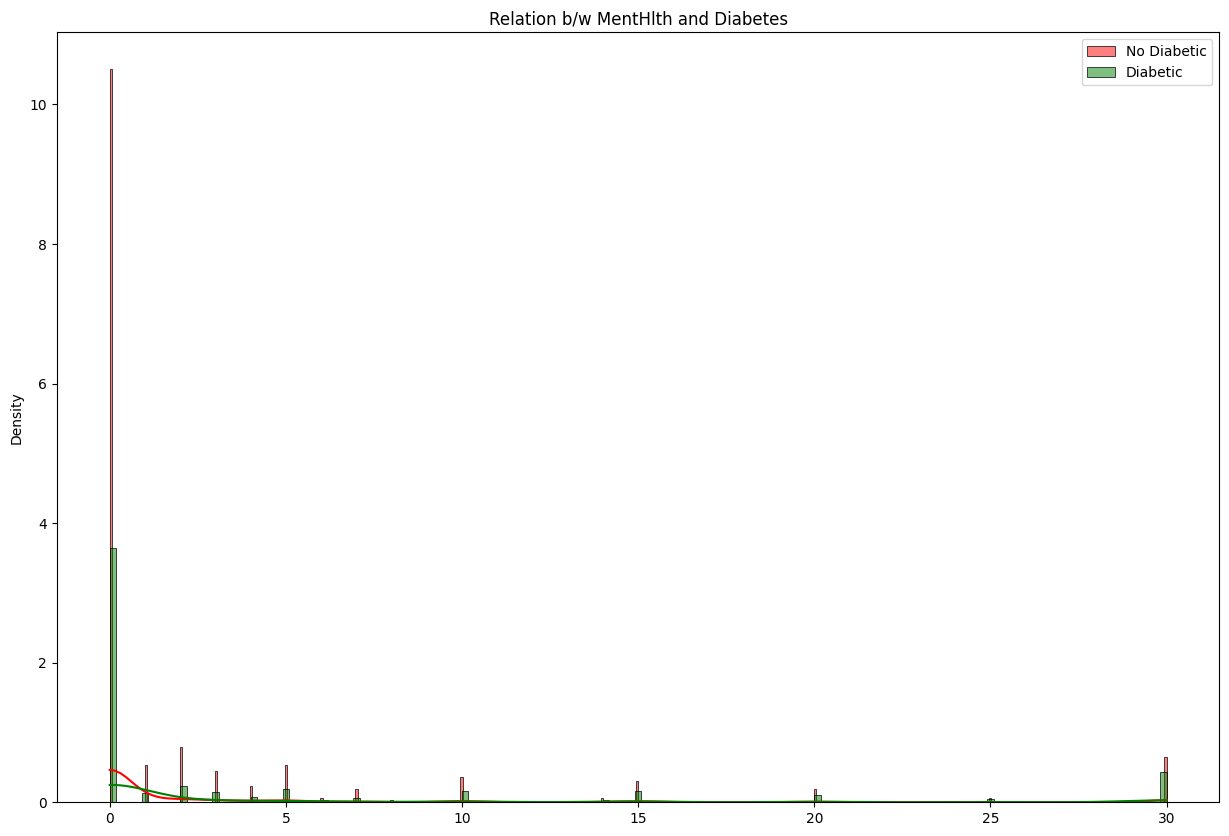

In [73]:


# Step 1: Filter the data for non-diabetic and diabetic cases
non_diabetic = cdc_data.filter(cdc_data.Diabetes_binary == 0).select("MentHlth").rdd.flatMap(lambda x: x).collect()
diabetic = cdc_data.filter(cdc_data.Diabetes_binary == 1).select("MentHlth").rdd.flatMap(lambda x: x).collect()

# Step 2: Plot the distributions
plt.figure(figsize=(15, 10))

sns.histplot(non_diabetic, color="r", label="No Diabetic", kde=True, stat='density', linewidth=0.5)
sns.histplot(diabetic, color="g", label="Diabetic", kde=True, stat='density', linewidth=0.5)

plt.title("Relation b/w MentHlth and Diabetes")
plt.legend()

plt.show()


In [74]:
# Step 1: Group by 'PhysHlth' and count the occurrences
physhlth_counts = cdc_data.groupBy("PhysHlth").count()

# Step 2: Convert to Pandas DataFrame
physhlth_counts_pd = physhlth_counts.toPandas()

# Step 3: Create the treemap using Plotly
fig = px.treemap(physhlth_counts_pd, path=['PhysHlth'], values='count', title="PhysHlth counts")
fig.show()

In [75]:
# Step 1: Group by 'PhysHlth' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy("PhysHlth", "Diabetes_binary_str").count()

# Step 2: Pivot the table to get the same result as transpose in Pandas
pivot_table = cross_tab.groupBy("PhysHlth").pivot("Diabetes_binary_str").agg(F.sum("count"))

# Step 3: Show the result
pivot_table.show()

+--------+--------+------------+
|PhysHlth|Diabetic|Non-Diabetic|
+--------+--------+------------+
|     8.0|     159|         650|
|     0.0|   16740|      143312|
|     7.0|     743|        3795|
|    29.0|      74|         141|
|    18.0|      35|         117|
|     1.0|    1188|       10200|
|    25.0|     394|         942|
|     4.0|     763|        3779|
|    23.0|      16|          40|
|    11.0|      12|          48|
|    21.0|     139|         524|
|    14.0|     473|        2114|
|    22.0|      23|          47|
|     3.0|    1289|        7206|
|    19.0|       3|          19|
|    28.0|     143|         379|
|     2.0|    2028|       12736|
|    17.0|      27|          69|
|    27.0|      21|          78|
|    10.0|    1290|        4305|
+--------+--------+------------+
only showing top 20 rows



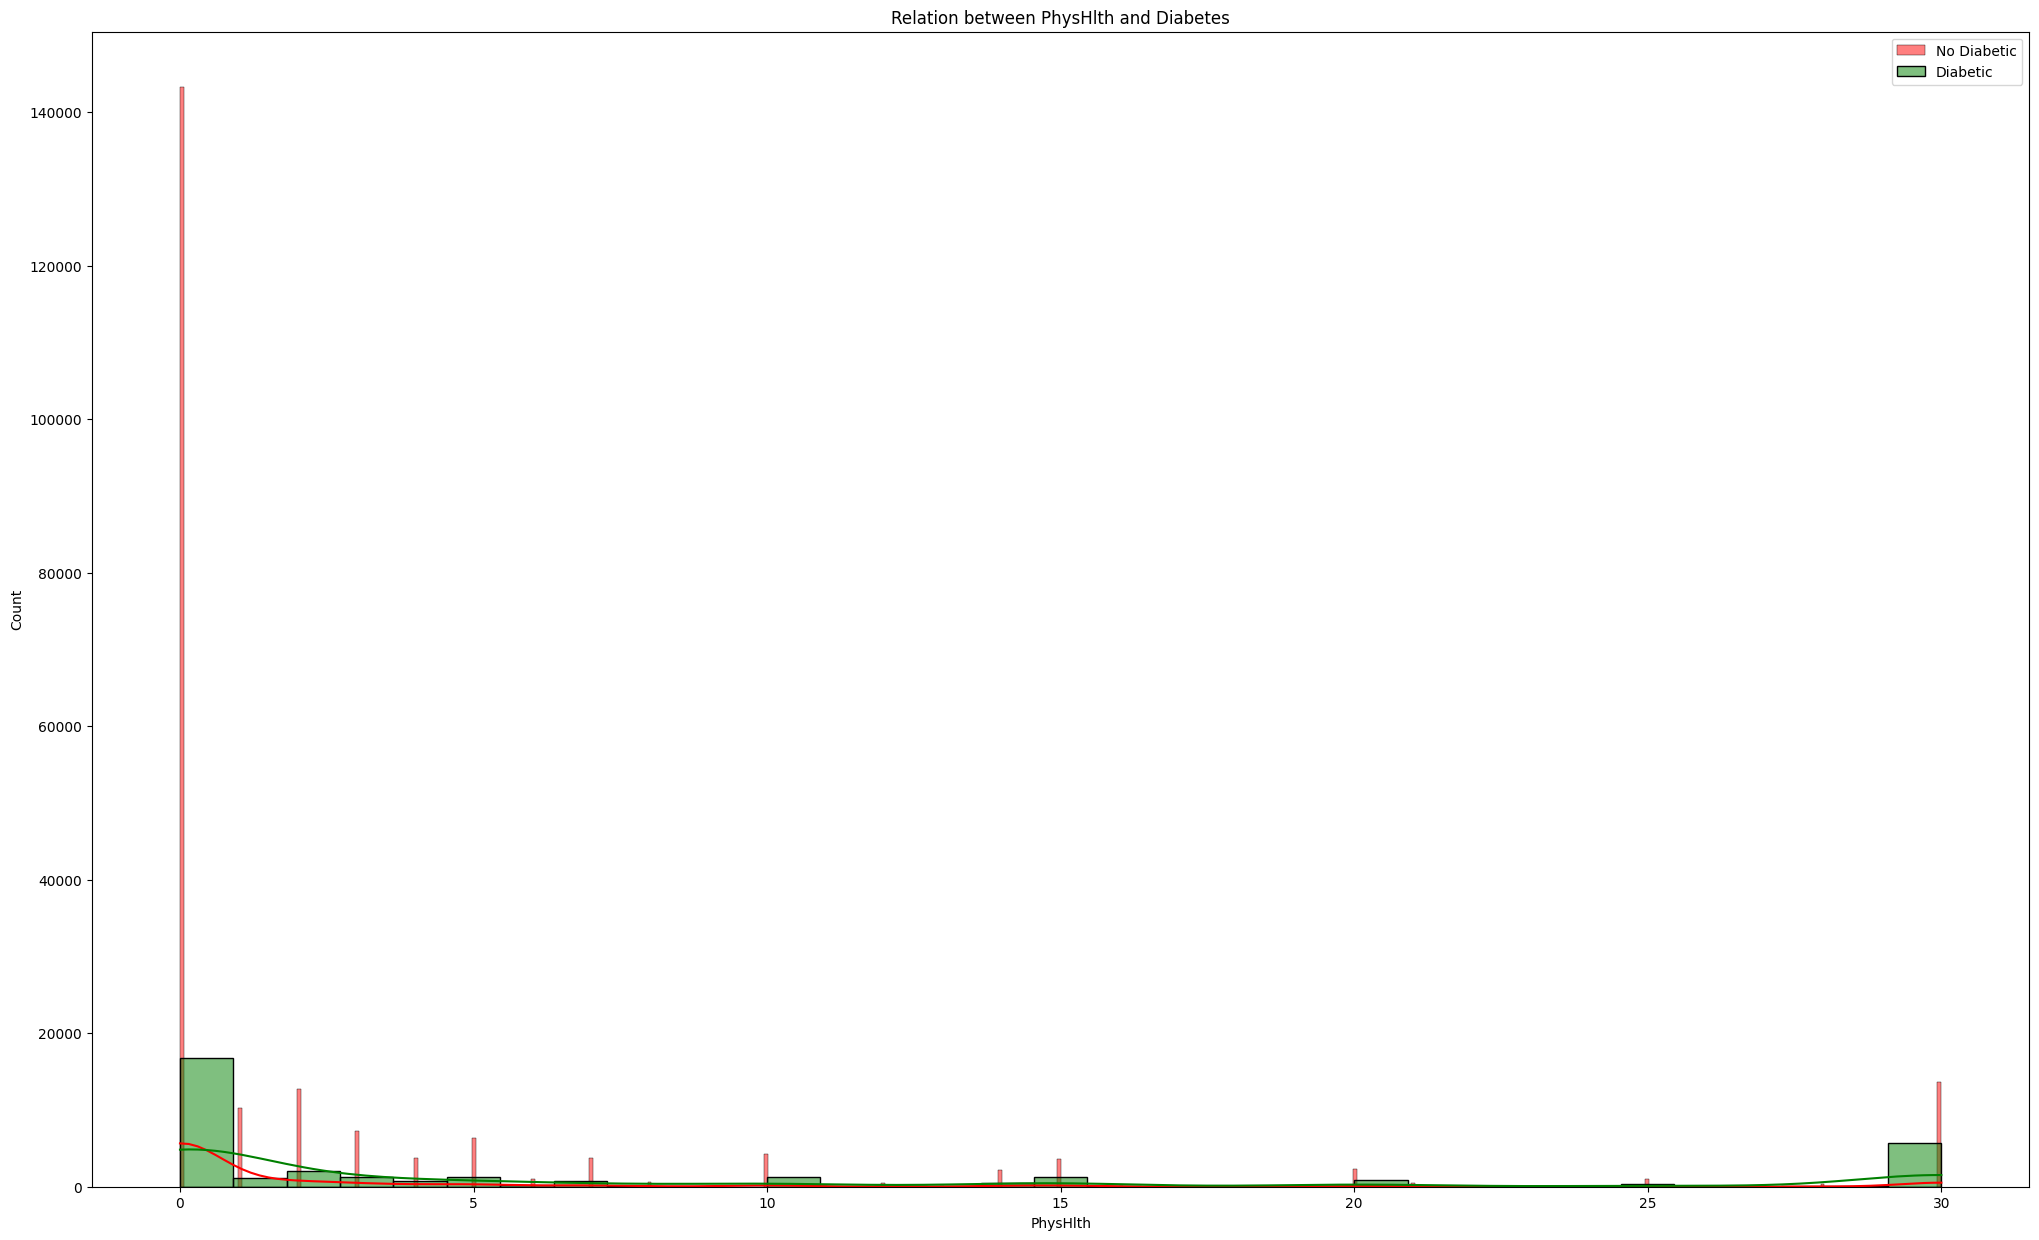

In [76]:

# Step 1: Filter the data into diabetic and non-diabetic groups
non_diabetic = cdc_data.filter(cdc_data.Diabetes_binary == 0).select("PhysHlth").toPandas()
diabetic = cdc_data.filter(cdc_data.Diabetes_binary == 1).select("PhysHlth").toPandas()

# Step 2: Plot the distribution using seaborn
plt.figure(figsize=(25, 15))
warnings.filterwarnings('ignore')

sns.histplot(non_diabetic["PhysHlth"], color="r", kde=True, label="No Diabetic")
sns.histplot(diabetic["PhysHlth"], color="g", kde=True, label="Diabetic")

plt.title("Relation between PhysHlth and Diabetes")
plt.legend()
plt.show()


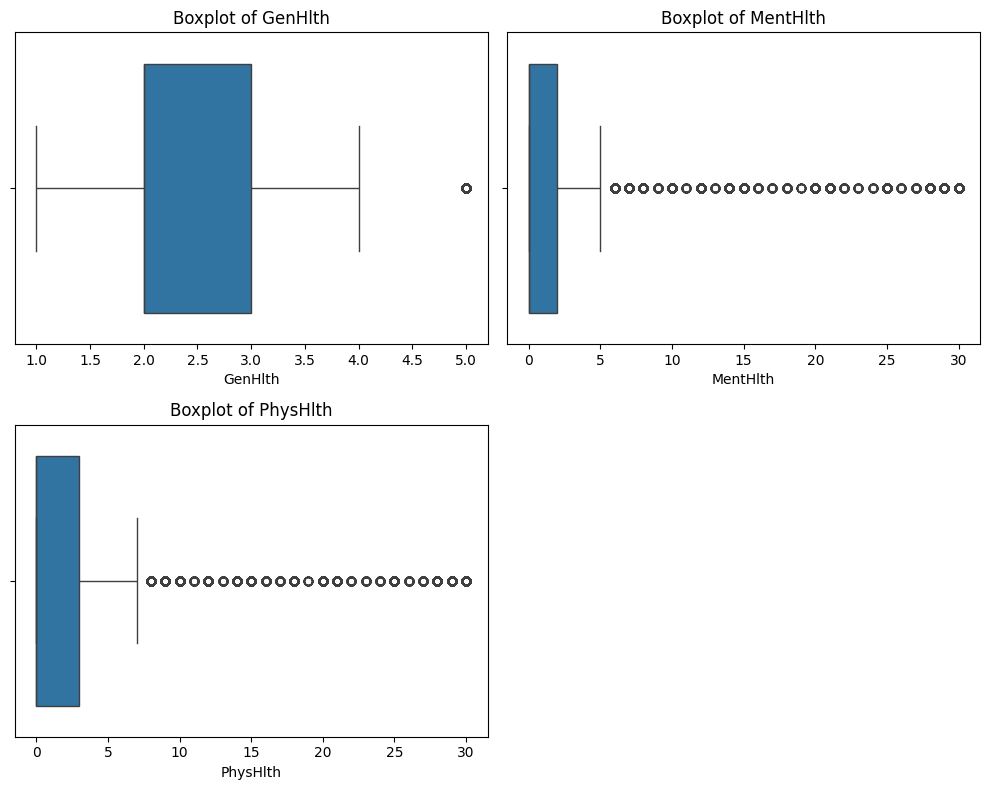

In [77]:
# Step 1: Select the relevant columns
columns = ['GenHlth', 'MentHlth', 'PhysHlth']
cdc_data_pandas = cdc_data.select(*columns).toPandas()

# Step 2: Plot the boxplots
plt.figure(figsize=(10, 8))
for i, col in enumerate(columns):
    plt.subplot(2, 2, i + 1)  # Create subplots in a 2x2 grid
    sns.boxplot(x=cdc_data_pandas[col])  # Create boxplot for each column
    plt.title(f"Boxplot of {col}")  # Set the title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [78]:
# Grouping by 'DiffWalk' and 'Diabetes_binary_str' and getting the count
crosstab_result = cdc_data.groupBy("DiffWalk", "Diabetes_binary_str").agg(F.count("*").alias("count"))

# Show the result
crosstab_result.show()

+--------+-------------------+------+
|DiffWalk|Diabetes_binary_str| count|
+--------+-------------------+------+
|     1.0|           Diabetic| 13121|
|     0.0|       Non-Diabetic|188780|
|     0.0|           Diabetic| 22225|
|     1.0|       Non-Diabetic| 29554|
+--------+-------------------+------+



**Health : GenHlth , MentHlth , PhysHlth and DiffWalk's vs Diabetes**

1.GenHlth has a major effect on diabetes.when GenHlth is not good then the risk of diabetes increases rapidly.

2.MentHlth is a major factor which causes Diabetes.when Menthlth is not stable for long time then the risk of diabetes increases.

3.same goes with PhysHlth

4.About half of people experiencing difficulty walking or climbing have diabetes

5.Mental and physical health has some outliers

**Social : Sex , Age , Education , and Income's vs Diabetes**

In [80]:

# Grouping by 'Sex' and 'Diabetes_binary_str' and getting the count
crosstab_result = cdc_data.groupBy("Sex", "Diabetes_binary_str").agg(F.count("*").alias("count"))

# Show the result
crosstab_result.show()


+---+-------------------+------+
|Sex|Diabetes_binary_str| count|
+---+-------------------+------+
|1.0|           Diabetic| 16935|
|0.0|       Non-Diabetic|123563|
|0.0|           Diabetic| 18411|
|1.0|       Non-Diabetic| 94771|
+---+-------------------+------+



In [81]:


# Create a crosstab between Age and Diabetes_binary_str
crosstab_df = cdc_data.crosstab("Age", "Diabetes_binary_str")

# Show the result
crosstab_df.show()


+-----------------------+--------+------------+
|Age_Diabetes_binary_str|Diabetic|Non-Diabetic|
+-----------------------+--------+------------+
|                    1.0|      78|        5622|
|                    9.0|    5733|       27511|
|                   12.0|    3403|       12577|
|                   10.0|    6558|       25636|
|                    5.0|    1051|       15106|
|                    6.0|    1742|       18077|
|                    4.0|     626|       13197|
|                    7.0|    3088|       23226|
|                   11.0|    5141|       18392|
|                    2.0|     140|        7458|
|                    8.0|    4263|       26569|
|                    3.0|     314|       10809|
|                   13.0|    3209|       14154|
+-----------------------+--------+------------+



In [83]:
# Grouping by Education and Diabetes_binary_str and counting occurrences
cross_tab = cdc_data.groupBy("Education", "Diabetes_binary_str").agg(F.count("*").alias("count"))

# Show the result
cross_tab.show()

+---------+-------------------+-----+
|Education|Diabetes_binary_str|count|
+---------+-------------------+-----+
|      3.0|           Diabetic| 2296|
|      2.0|       Non-Diabetic| 2860|
|      2.0|           Diabetic| 1183|
|      5.0|           Diabetic|10354|
|      1.0|           Diabetic|   47|
|      4.0|       Non-Diabetic|51684|
|      4.0|           Diabetic|11066|
|      5.0|       Non-Diabetic|59556|
|      3.0|       Non-Diabetic| 7182|
|      6.0|       Non-Diabetic|96925|
|      1.0|       Non-Diabetic|  127|
|      6.0|           Diabetic|10400|
+---------+-------------------+-----+



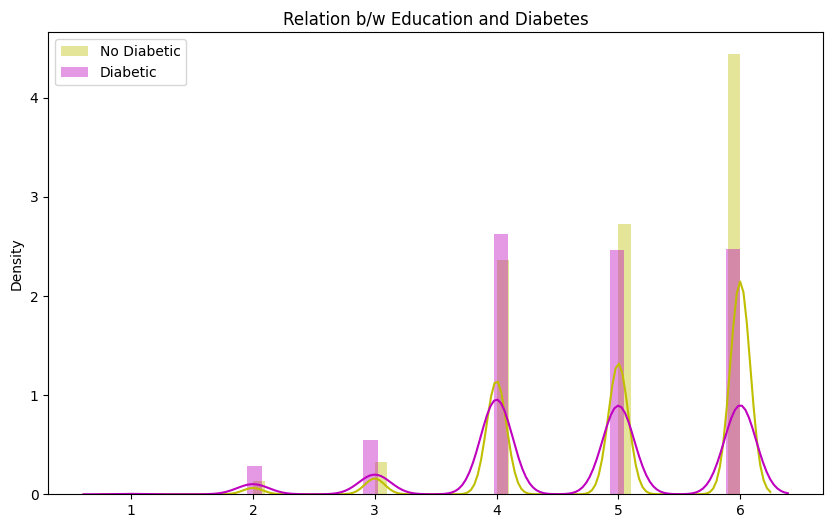

In [84]:
# Collect the data for No Diabetic (Diabetes_binary == 0)
no_diabetic_education = cdc_data.filter(cdc_data.Diabetes_binary == 0).select("Education").rdd.flatMap(lambda x: x).collect()

# Collect the data for Diabetic (Diabetes_binary == 1)
diabetic_education = cdc_data.filter(cdc_data.Diabetes_binary == 1).select("Education").rdd.flatMap(lambda x: x).collect()

# Now plotting using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.distplot(no_diabetic_education, color="y", label="No Diabetic")
sns.distplot(diabetic_education, color="m", label="Diabetic")

plt.title("Relation b/w Education and Diabetes")
plt.legend()
plt.show()

In [85]:
# Group by 'Income' and 'Diabetes_binary_str' and count the occurrences
cross_tab = cdc_data.groupBy('Income', 'Diabetes_binary_str').agg(F.count('*').alias('count'))

# Show the result
cross_tab.show()

+------+-------------------+-----+
|Income|Diabetes_binary_str|count|
+------+-------------------+-----+
|   7.0|           Diabetic| 5265|
|   3.0|           Diabetic| 3568|
|   2.0|       Non-Diabetic| 8697|
|   8.0|           Diabetic| 7195|
|   2.0|           Diabetic| 3086|
|   5.0|           Diabetic| 4504|
|   1.0|           Diabetic| 2383|
|   4.0|       Non-Diabetic|16081|
|   4.0|           Diabetic| 4054|
|   5.0|       Non-Diabetic|21379|
|   8.0|       Non-Diabetic|83190|
|   3.0|       Non-Diabetic|12426|
|   6.0|       Non-Diabetic|31179|
|   7.0|       Non-Diabetic|37954|
|   1.0|       Non-Diabetic| 7428|
|   6.0|           Diabetic| 5291|
+------+-------------------+-----+



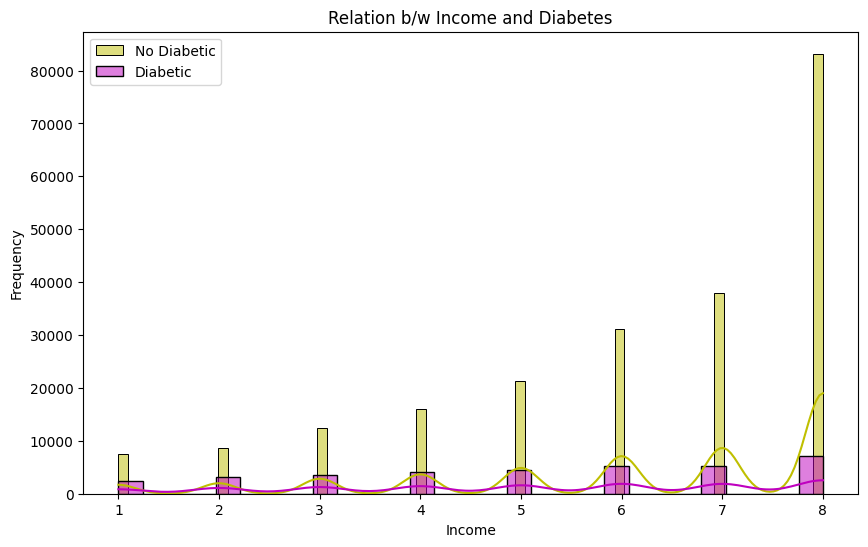

In [87]:
# Filter the data for No Diabetic (Diabetes_binary == 0) and Diabetic (Diabetes_binary == 1)
no_diabetic = cdc_data.filter(cdc_data.Diabetes_binary == 0).select('Income').rdd.flatMap(lambda x: x).collect()
diabetic = cdc_data.filter(cdc_data.Diabetes_binary == 1).select('Income').rdd.flatMap(lambda x: x).collect()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(no_diabetic, color="y", kde=True, label="No Diabetic")
sns.histplot(diabetic, color="m", kde=True, label="Diabetic")

# Set plot title and labels
plt.title("Relation b/w Income and Diabetes")
plt.xlabel("Income")
plt.ylabel("Frequency")

# Show legend
plt.legend()
plt.show()

**Social : Sex , Age , Education , and Income's vs Diabetes : Conclusion**
1. male and female are equally vulnerable for Diabetes.

2. people older than 45 are more vulnerable for diabetes then the younger ones.when the age increase the number of diabetic people also increas.

3. when Education is going Higher the number of Diabetic people is decreasing.

4. people with lower income has more risk of diabetes then the Higher ones.

 **EDA: CDC Data : Conclusions**
 1. Target Feature of the Data is Diabetes_binary.

2. dataset has 15 Discrete type and 7 continuous type feature variables.

3. Dataset dose not have missing values(null values).

4. major feature variables for Diabetes are : HIghBP , HighChol , BMI, PhysicalActivity , GenHlth , MentHlth , PhysHlth , Age , Eduation and Income.

5. Feature variables which increases the risk of Diabetes togather are : Smoking and HvyAlcoholConsump , Stroke and HeartDiseaseorAttack , HighBP and HighChol.

6. Feature variable Which is least effective on Diabetes , but they can help in decreasing the risk Diabetes are : Fruits , Veggies , AnyHealthcare , CholChek.

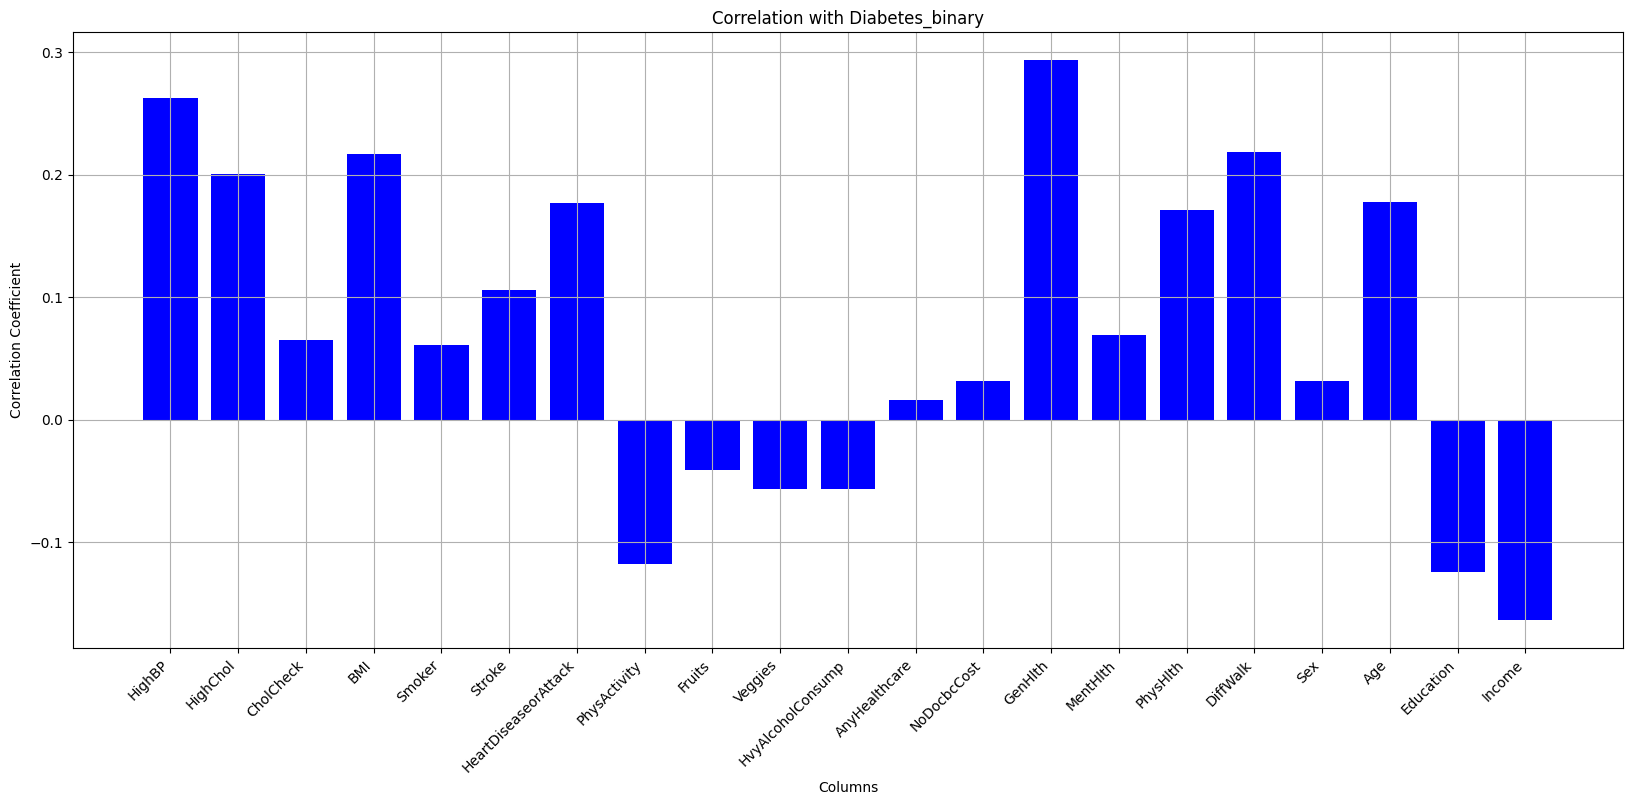

In [26]:
numeric_columns = [col for col in cdc_data.columns if col != 'Diabetes_binary']

# Assemble the numeric columns into a vector (excluding 'Diabetes_binary')
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
cdc_data_vector = assembler.transform(cdc_data)

# Compute the correlation of each column with 'Diabetes_binary'
diabetes_col = 'Diabetes_binary'

correlations = {}
for column in numeric_columns:
    corr_value = cdc_data.stat.corr(column, diabetes_col)
    correlations[column] = corr_value

# Convert the correlation dictionary to a list for plotting
corr_values = list(correlations.values())
column_names = list(correlations.keys())

# Plot the correlations
plt.figure(figsize=(20, 8))
plt.bar(column_names, corr_values, color='blue')
plt.title("Correlation with Diabetes_binary")
plt.xlabel("Columns")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

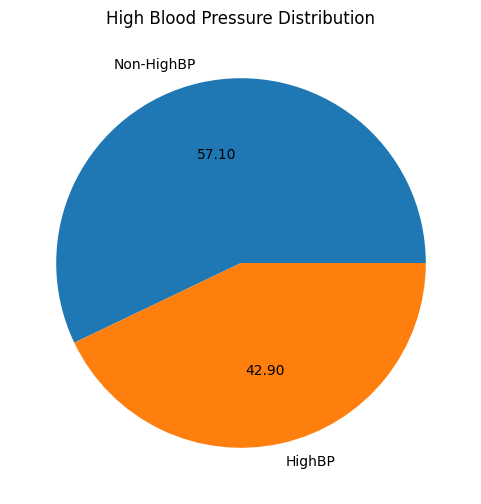

In [49]:
labels = ["Non-HighBP", "HighBP"]

# Count the occurrences of 'HighBP' values using groupBy
highbp_counts = cdc_data.groupBy("HighBP").count().toPandas()

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(highbp_counts['count'], labels=labels, autopct='%.02f')
plt.title('High Blood Pressure Distribution')
plt.show()

In [50]:
cross_tab = cdc_data.groupBy("HighBP", "Diabetes_binary_str").count()

# Show the cross-tabulation result
cross_tab.show()

+------+-------------------+------+
|HighBP|Diabetes_binary_str| count|
+------+-------------------+------+
|   1.0|           Diabetic| 26604|
|   0.0|       Non-Diabetic|136109|
|   0.0|           Diabetic|  8742|
|   1.0|       Non-Diabetic| 82225|
+------+-------------------+------+



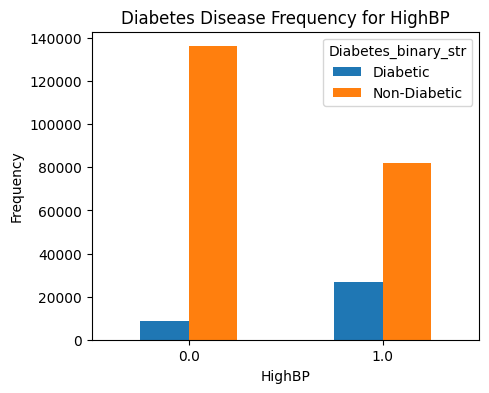

In [51]:
# Group by 'HighBP' and 'Diabetes_binary_str' and count occurrences
cross_tab = cdc_data.groupBy("HighBP", "Diabetes_binary_str").count()

# Convert to Pandas DataFrame for plotting
cross_tab_pd = cross_tab.toPandas()

# Pivot the Pandas DataFrame to make HighBP values as rows and Diabetes_binary_str as columns
cross_tab_pivot = cross_tab_pd.pivot(index='HighBP', columns='Diabetes_binary_str', values='count')

# Plot the bar chart
cross_tab_pivot.plot(kind="bar", figsize=(5, 4))

# Adding labels and title
plt.title('Diabetes Disease Frequency for HighBP')
plt.xlabel("HighBP")
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [53]:

# Step 1: Count occurrences of each combination of 'Diabetes_binary_str' and 'HighBP'
highbp_counts = cdc_data.groupBy("Diabetes_binary_str", "HighBP").count()

# Step 2: Calculate the total count for each 'Diabetes_binary_str'
total_counts = cdc_data.groupBy("Diabetes_binary_str").count().withColumnRenamed("count", "total_count")

# Step 3: Join the two DataFrames to calculate the percentage
highbp_percentage = highbp_counts.join(total_counts, on="Diabetes_binary_str") \
    .withColumn("percentage", (F.col("count") / F.col("total_count")) * 100)

# Step 4: Show the result
highbp_percentage.select("Diabetes_binary_str", "HighBP", "percentage").show()

+-------------------+------+------------------+
|Diabetes_binary_str|HighBP|        percentage|
+-------------------+------+------------------+
|           Diabetic|   0.0| 24.73264301476829|
|           Diabetic|   1.0| 75.26735698523171|
|       Non-Diabetic|   0.0|62.339809649436184|
|       Non-Diabetic|   1.0|37.660190350563816|
+-------------------+------+------------------+



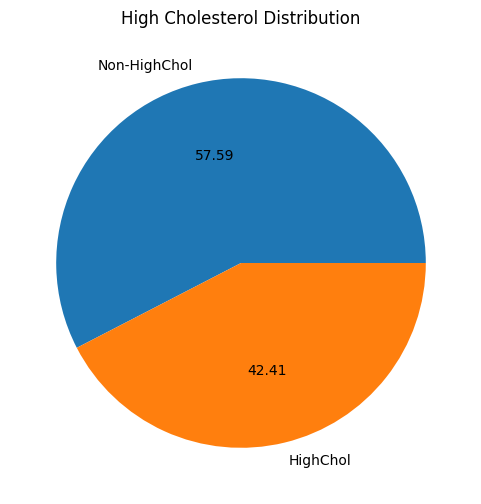

In [54]:
# Group by 'HighChol' and count the occurrences
highchol_counts = cdc_data.groupBy("HighChol").count().toPandas()

# Labels for the pie chart
labels = ["Non-HighChol", "HighChol"]

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(highchol_counts['count'], labels=labels, autopct='%.02f')
plt.title('High Cholesterol Distribution')
plt.show()

In [55]:
# Group by 'HighChol' and 'Diabetes_binary_str' and count occurrences
cross_tab = cdc_data.groupBy("HighChol", "Diabetes_binary_str").count()

# Show the result
cross_tab.show()

+--------+-------------------+------+
|HighChol|Diabetes_binary_str| count|
+--------+-------------------+------+
|     1.0|           Diabetic| 23686|
|     0.0|       Non-Diabetic|134429|
|     0.0|           Diabetic| 11660|
|     1.0|       Non-Diabetic| 83905|
+--------+-------------------+------+



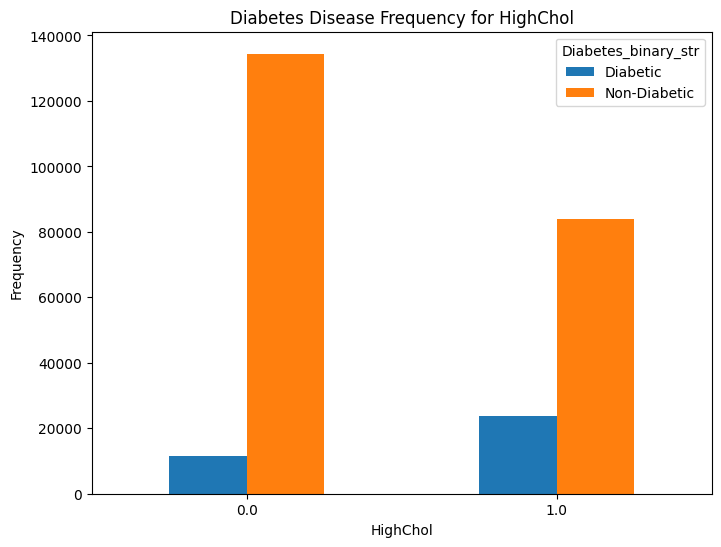

In [56]:
# Step 1: Group by 'HighChol' and 'Diabetes_binary_str' and count occurrences
cross_tab = cdc_data.groupBy("HighChol", "Diabetes_binary_str").count()

# Step 2: Convert to Pandas DataFrame
cross_tab_pd = cross_tab.toPandas()

# Step 3: Pivot the Pandas DataFrame to get 'HighChol' as index and 'Diabetes_binary_str' as columns
cross_tab_pivot = cross_tab_pd.pivot(index='HighChol', columns='Diabetes_binary_str', values='count')

# Step 4: Plot the bar chart
cross_tab_pivot.plot(kind="bar", figsize=(8, 6))

# Adding labels and title
plt.title('Diabetes Disease Frequency for HighChol')
plt.xlabel("HighChol")
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [57]:
# Step 1: Count occurrences of each combination of 'Diabetes_binary_str' and 'HighChol'
highchol_counts = cdc_data.groupBy("Diabetes_binary_str", "HighChol").count()

# Step 2: Calculate the total count for each 'Diabetes_binary_str'
total_counts = cdc_data.groupBy("Diabetes_binary_str").count().withColumnRenamed("count", "total_count")

# Step 3: Join the two DataFrames to calculate the percentage
highchol_percentage = highchol_counts.join(total_counts, on="Diabetes_binary_str") \
    .withColumn("percentage", (F.col("count") / F.col("total_count")) * 100)

# Step 4: Show the result
highchol_percentage.select("Diabetes_binary_str", "HighChol", "percentage").show()

+-------------------+--------+------------------+
|Diabetes_binary_str|HighChol|        percentage|
+-------------------+--------+------------------+
|           Diabetic|     0.0| 32.98817405081198|
|           Diabetic|     1.0| 67.01182594918804|
|       Non-Diabetic|     0.0|61.570346350087476|
|       Non-Diabetic|     1.0|38.429653649912524|
+-------------------+--------+------------------+



In [58]:
# Step 1: Count occurrences of 'Diabetes_binary_str' for each combination of 'HighBP' and 'HighChol'
diabetes_counts = cdc_data.groupBy("HighBP", "HighChol", "Diabetes_binary_str").count()

# Step 2: Calculate the total count for each combination of 'HighBP' and 'HighChol'
total_counts = cdc_data.groupBy("HighBP", "HighChol").count().withColumnRenamed("count", "total_count")

# Step 3: Join the two DataFrames to calculate the percentage
diabetes_percentage = diabetes_counts.join(total_counts, on=["HighBP", "HighChol"]) \
    .withColumn("percentage", (F.col("count") / F.col("total_count")) * 100)

# Step 4: Show the result
diabetes_percentage.select("HighBP", "HighChol", "Diabetes_binary_str", "percentage").show()

+------+--------+-------------------+------------------+
|HighBP|HighChol|Diabetes_binary_str|        percentage|
+------+--------+-------------------+------------------+
|   1.0|     1.0|       Non-Diabetic| 70.28611197030622|
|   1.0|     1.0|           Diabetic| 29.71388802969378|
|   0.0|     1.0|           Diabetic|10.419044513288766|
|   0.0|     1.0|       Non-Diabetic| 89.58095548671123|
|   1.0|     0.0|       Non-Diabetic| 83.26654440897462|
|   1.0|     0.0|           Diabetic| 16.73345559102538|
|   0.0|     0.0|       Non-Diabetic| 95.81142072213501|
|   0.0|     0.0|           Diabetic| 4.188579277864992|
+------+--------+-------------------+------------------+



In [60]:
# Filter the data where BMI <= 20
filtered_data = cdc_data.filter(cdc_data["BMI"] <= 20)

# Group by 'Diabetes_binary' and count the occurrences
diabetes_counts = filtered_data.groupBy("Diabetes_binary").count()

# Show the result
diabetes_counts.show()

+---------------+-----+
|Diabetes_binary|count|
+---------------+-----+
|            0.0|12877|
|            1.0|  545|
+---------------+-----+



In [1]:
filtered_data = cdc_data.filter((cdc_data["BMI"] > 20) & (cdc_data["BMI"] <= 50))

# Group by 'Diabetes_binary_str' and count the occurrences
diabetes_counts = filtered_data.groupBy("Diabetes_binary_str").count()

# Show the result
diabetes_counts.show()

NameError: name 'cdc_data' is not defined